## Calculate surface-forced watermass transformation
Presently, information about the products, e.g. names of variables is hard-coded. Could improve robustness by specifying generic names.

In [1]:
%load_ext autoreload
%autoreload 2
from dask.diagnostics import ProgressBar
import so_decadal_variability as so
import numpy as np
import xarray as xr
import os
import gsw

In [2]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37831 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 66.80 GB


In [6]:
fluxname='era5'
oceanname='en4'
density = 'sigma0'
timeslice = slice('1980','2018')
dg = 0.1
density_edges = np.arange(1026,1028.5,dg)
save = False
# Load data
ds = so.process.loaddata(fluxname,oceanname,timeslice,onoceangrid=False)
# Get grid
ds, xgrid = so.grid.get_xgcm(ds,gridlon='longitude',gridlat='latitude')
# Calculate a density variable
ds['sigma0'] = gsw.sigma0(ds['sa'].isel(depth=0).squeeze(),ds['sst'])+1000
ds['b'] = xr.ones_like(ds['sigma0'])
ds['vol4d'] = ds['cell_area']*ds['dz']
ds = ds.rename({'longitude':'lon','latitude':'lat'})
ds = ds.chunk(chunks={'time':1})
# Calculate WMT
G = so.wmt.calc_watermasstransformation(ds,xgrid,density_edges,density=density,b_ones=False)

# Save
if save:
    with ProgressBar():
        localdir = '../data/processed/'+fluxname+'_'+oceanname
        if ~os.path.isdir(localdir):
            !mkdir $localdir
        filename = 'G.'+density+'.'+str(dg)
        if (density=='gamman') & b_cap:
            filename = filename+'.b_cap-'+str(cap)
        G.to_netcdf(localdir+'/'+filename+'.nc')

In [7]:
ds

<xarray.Dataset>
Dimensions:         (bnds: 2, depth: 42, depth_i: 43, lat: 241, latitude_left: 241, lon: 1440, longitude_left: 1440, time: 468)
Coordinates:
  * time            (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
  * lon             (lon) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * lat             (lat) float32 -30.0 -30.25 -30.5 ... -89.5 -89.75 -90.0
  * depth           (depth) float32 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
  * longitude_left  (longitude_left) float32 -180.1 -179.9 ... 179.4 179.6
  * latitude_left   (latitude_left) float32 -29.88 -30.12 ... -89.62 -89.88
  * depth_i         (depth_i) float32 0.0 10.05 20.12 ... 5.201e+03 5.5e+03
Dimensions without coordinates: bnds
Data variables: (12/22)
    fw              (time, lat, lon) float32 dask.array<chunksize=(1, 241, 1440), meta=np.ndarray>
    ht              (time, lat, lon) float32 dask.array<chunksize=(1, 241, 1440), meta=np.ndarray>
    sic             (time, lat, lon) float32 dask.array<chunksize=(1, 241, 1440), meta=np.ndarray>
    sr              (time, lat, lon) float32 dask.array<chunksize=(1, 241, 1440), meta=np.ndarray>
    sst             (time, lat, lon) float32 dask.array<chunksize=(1, 241, 1440), meta=np.ndarray>
    time_bnds       (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    dxC             (lon, lat) float32 dask.array<chunksize=(1440, 241), meta=np.ndarray>
    dyC             (lon, lat) float32 dask.array<chunksize=(1440, 241), meta=np.ndarray>
    dz              (depth) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    sigma0          (time, lat, lon) float64 dask.array<chunksize=(1, 241, 1440), meta=np.ndarray>
    b               (time, lat, lon) float64 dask.array<chunksize=(1, 241, 1440), meta=np.ndarray>
    vol4d           (lat, lon, depth) float64 dask.array<chunksize=(241, 1440, 42), meta=np.ndarray>

In [8]:
with ProgressBar():
    G.load()

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


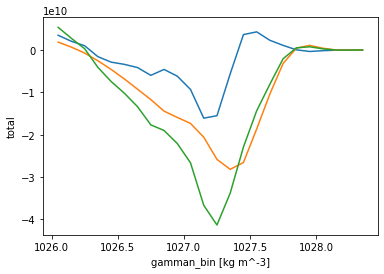

In [4]:
G['heat'].mean('time').plot()
G['fw'].mean('time').plot()
G['total'].mean('time').plot()

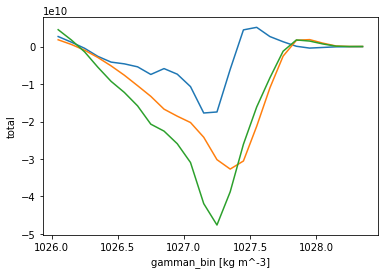

In [103]:
G['heat'].mean('time').plot()
G['fw'].mean('time').plot()
G['total'].mean('time').plot()

In [40]:
G['heat'].sel(time='2002-10-01',gamman_bin=1027.85,method='nearest')

<xarray.DataArray 'heat' ()>
array(5.75621555e+08)
Coordinates:
    time        datetime64[ns] 2002-10-01
    gamman_bin  float64 1.028e+03

In [71]:
dsnow = ds.sel(time=slice('2002-09-01','2002-10-01'))

In [72]:
# from xhistogram.xarray import histogram

bins=np.arange(1026,1028.5,0.1)
F = so.wmt.calc_densityflux(dsnow,xgrid)
gbFV = ds['gamman']*ds['b']*F['heat']*ds['vol4d']
# dsnow['gamman'].sel(depth=0,method='nearest').plot()

In [74]:
condition = (dsnow['gamman']>1027.7)&(dsnow['gamman']<=1027.8)
gbFV.where(condition,0).isel(time=0).sum(xr.ALL_DIMS).values

array(4.2765666e+09)

In [81]:
dsnow['b'].max().values

array(inf)

In [68]:
G['heat']['gamman_bin'].diff('gamman_bin')

<xarray.DataArray 'gamman_bin' (gamman_bin: 23)>
array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
Coordinates:
  * gamman_bin  (gamman_bin) float64 1.026e+03 1.026e+03 ... 1.028e+03 1.028e+03

In [9]:
ds

<xarray.Dataset>
Dimensions:     (bnds: 2, depth: 42, depth_i: 43, lat: 241, lat_left: 241, lon: 1440, lon_left: 1440, time: 468)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2018-12-01
  * lon         (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat         (lat) float32 -30.0 -30.25 -30.5 -30.75 ... -89.5 -89.75 -90.0
  * depth       (depth) float32 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
  * lon_left    (lon_left) float32 -180.1 -179.9 -179.6 ... 179.1 179.4 179.6
  * lat_left    (lat_left) float32 -29.88 -30.12 -30.38 ... -89.38 -89.62 -89.88
  * depth_i     (depth_i) float32 0.0 10.05 20.12 ... 5.201e+03 5.5e+03
Dimensions without coordinates: bnds
Data variables: (12/15)
    fw          (time, lat, lon) float32 dask.array<chunksize=(468, 241, 1440), meta=np.ndarray>
    ht          (time, lat, lon) float32 dask.array<chunksize=(468, 241, 1440), meta=np.ndarray>
    sr          (time, lat, lon) float32 dask.array<chunksize=(468, 241, 1440), meta=np.ndarray>
    time_bnds   (time, bnds) datetime64[ns] dask.array<chunksize=(468, 2), meta=np.ndarray>
    depth_bnds  (depth, bnds) float32 dask.array<chunksize=(42, 2), meta=np.ndarray>
    sa          (time, depth, lat, lon) float32 dask.array<chunksize=(468, 42, 241, 1440), meta=np.ndarray>
    ...          ...
    mask        (lat, lon) float64 dask.array<chunksize=(241, 1440), meta=np.ndarray>
    dxG         (lon_left, lat) float32 2.403e+04 2.397e+04 ... 121.1 -0.001213
    dyG         (lon, lat_left) float32 nan -2.775e+04 ... -2.775e+04 -2.775e+04
    dxC         (lon, lat) float32 2.403e+04 2.397e+04 ... 121.1 -0.001213
    dyC         (lon, lat) float32 -2.775e+04 -2.775e+04 ... -2.775e+04 nan
    dz          (depth) float32 10.05 10.07 10.1 10.14 ... 298.8 299.1 299.4